In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import time
from sklearn import preprocessing
# from numba import vectorize
# from numba import cuda
# from numba import autojit
# import cupy as cp

## Cost/activation

In [2]:
# @cuda.jit
def cost_MSE(t,y_hat, derivative=0):
    if derivative:
            return -(t - y_hat)
    return np.mean(1/2*np.sum(np.power(t - y_hat, 2),\
                      axis=0))
# @cuda.jit(device=True)
# @cuda.jit
# @autojit
def logistic_sigmoid(x, derivative=0):    
    sigm = 1/(1 + np.exp(-x))
    if len(sigm.shape) < 2:
        sigm = sigm.reshape(sigm.shape[0],1)
        
    if derivative:
        return sigm*(1. - sigm)
    return sigm

## NN backend

slight modification from previous network here. It uses a non normalized output (does not become a probability), so now both outputs can be either 0's or 1's

In [3]:
# >>>>>>>>>>>>>>>>>>> init_weights_biases >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
# W, B = init_weights_biases(4, 3, [2,2])
#no_hidden_units: needs a list with at least one element
# @cuda.jit(device=True)
def init_weights_biases(no_of_features, no_outputs, no_hidden_units, seed=1):
    
    W = []
    B = []
    rows, columns = 0, 0 
    last = len(no_hidden_units)
    np.random.seed(seed)
    
    if no_hidden_units: #list is not empty
        for i in range(last+1):
            if i == 0: #first weight
                rows = no_hidden_units[i]
                columns = no_of_features
            elif i > 0 and i < last:
                rows = no_hidden_units[i]
                columns = no_hidden_units[i-1]
            else: #last
                columns = rows # list ran out of indeces, so use last one
                rows = no_outputs            

            W.insert(i, np.random.randn(rows, columns))
            B.insert(i, np.zeros((rows, 1)))
    else: # no hidden units (perceptron)
        W.insert(0, np.random.randn(no_outputs, no_of_features))
        B.insert(0, np.zeros((no_outputs, 1)))
    
    dummy_param = 0
    param = 0
    for i in range(len(W)):
        dummy_param = W[i].shape[0] * W[i].shape[1]
        param += dummy_param
        
#     W.append(param) #number of learnable weights
    
    return W, B, param

# >>>>>>>>>>>>>>>>>>> forward_prop >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
    # W1, b1, W2, b2 = init_weights_biases(no_hidden_units=8)
    # Z, A, Y = forward_prop(W, B, X)
    # X has n features x M samples
# @autojit
# @cuda.jit
def forward_prop(W, B, X):
    no_of_samples = X.shape[1]
     #last weight matrix, rows correspond to outputs
    no_of_outputs = W[-2].shape[0] #index -1 is the number of learnable weights
    
    Z = []
    A = []
    A.append(X) #first layer is an activation
    
    for i in range(len(W)): #to avoid the last two indeces
        Z.insert(i, W[i] @ A[i] + B[i])
        A.insert(i+1, logistic_sigmoid(Z[i]))
    
#     Y = np.zeros((no_of_samples, no_of_outputs))
#     #scaling to making the pair a probability
#     Y = np.divide(A[i+1], np.sum(A[i+1], axis=0)) #columns are the samples now
    Y = A[i+1]
    return Z, A, Y

# >>>>>>>>>>>>>>>>>>> backprop >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
# W1, b1, W2, b2 = init_weights_biases(no_hidden_units=8)
# A1, A2, Y = forward_prop(W1, b1, W2, b2, X)
# grad_mid_layer, grad_output = backprop(W2, A1, A2, X, Y, t)
# backprop(W2, A1, A2, X, Y, t)
# @cuda.jit(device=True)

# @cuda.jit
# @autojit
def backprop(W, Z, A, Y_hat, T):
    
    output_index = len(W)-1 # if 3, starts at 2
    error = {}
    
    error_output = cost_MSE(T,Y_hat, derivative=1) * logistic_sigmoid(Z[-1], derivative=1)
    error[output_index] = error_output
    
    dJ_dW = {}
    for i in range(output_index-1,-1,-1):
         # doesn't get to W[0], so updated after the foor loop again
#         dJ_dW.insert(i+1, error[i+1] @ A[i+1].T)
        dJ_dW[i+1] = error[i+1] @ A[i+1].T
        
        error_dummy = (W[i+1].T @ error[i+1]) * logistic_sigmoid(Z[i], derivative=1)
#         error.insert(i, error_dummy)
        error[i] = error_dummy
    
    dJ_dW[0] = error[0] @ A[0].T
    
    return dJ_dW

## NN frontend 1 

    train, predict functions

In [4]:
# >>>>>>>>>>>>>>>>>>> train >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
    # all samples (X), 4 x 2, are fed
    # X: dataset, n samples x N features
    # T: binary labels, n labels x L number of ouputs
    # hidden_layers : list with number of neurons for each inner layer.
        # e.g. [3, 4] will yield two layers with 3 and 4 units respectively
    # this function needs n samples > 1 (batch optimization).
# @cuda.jit(device=True)
# @autojit
def train(X, T, hidden_layers=[2], epochs=500,\
          rho=.1, normalize_data=False, show_cost=0, seed=1, w_transfer=[]):    
    
    if normalize_data:
        scaler = preprocessing.StandardScaler()
        X = scaler.fit_transform(X)
    
    no_of_features = X.shape[1]
    no_samples = X.shape[0]
    no_outputs = T.shape[1]
    
    W, B, param = init_weights_biases(no_of_features,\
                                      no_outputs, hidden_layers, seed=1)
    
    if w_transfer:
        W=w_transfer
        
    Y_hat = np.zeros((no_outputs, X.shape[0]))    

    N = int(np.round(epochs/20))
    i_for_show_cost = np.round(np.linspace(0,epochs,N))
    
    ###NESTED function
    def display_NN_info():
        print("* NN ************************************")
        print("   no. inputs (layer 1): " + str(no_of_features) )
        for k in range(len(hidden_layers)):
            print("   layer " + str(k+2) + ": " + str(hidden_layers[k]) + " units")
        print("   output layer ("+ str(k+3) + "): " + str(no_outputs) )
        print("   learnable weights: " + str(param) )
        print("   max epochs: " + "{:,}".format(epochs) )
        print("   learning rate(rho): " + str(rho) )
        
    display_NN_info()
    time.sleep(4)
    #loop variables, along with other variables and lists (cost, accuracy)
    # that are returned by the function
    cost_final = []
    accuracy = []
    iter_passed = []
    match = 0
    idx_done = 0
    converged = False
    k_cost = 0
    acc_count = 0
    for i in range(epochs):
        Z, A, Y_hat = forward_prop(W, B, X.T)
        dJ_dW = backprop(W, Z, A, Y_hat, T.T)
        
        sign = 1
    
        #grad descent
        for a in range(len(W)):
            W[a] = W[a] - sign*rho*dJ_dW[a]
        
        if match <=5:
            idx_done = i + 1
        
        if is_equal_in_boolean_terms(Y_hat.T, T):
            match += 1            
                
            if match > 6 and match < 7:
                idx_done = i + 1 # already predicts corretly all the time
            
        if match > 20: #seeing the match 20 times 
            converged = True #makes the predictions more confident
            break
        
        
        cost_final.insert(i,cost_MSE(T, Y_hat.T))
        accuracy.insert(i,calc_accuracy(T, Y_hat.T))
        iter_passed.insert(i,i)
        
        if accuracy[i] == 100:
            acc_count +=1
        
#         if acc_count > 100_000:
#             break
            
        if show_cost and i_for_show_cost[k_cost] == i:
            print("   " + str(i) + " iteration, accuracy: "+ str(accuracy[i])+ "%")
            print("   cost: " + str(cost_final[i]))
            k_cost += 1        
        
    if converged:
        print("   Converged in " + str(idx_done) + " iterations")
    else:
        print("   Did not converge.")
    print()
    if show_cost:
        plt.scatter(iter_passed, cost_final, s=1, color="red")
        plt.title("iterations X cost")
        plt.xlabel("iterations")
        plt.ylabel("cost")
        
    return [W, B, Y_hat.T, X, cost_final, epochs,\
            idx_done, converged, rho, normalize_data, accuracy]

# >>>>>>>>>>>>>>>>>>> predict >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
    # X: dataset, n samples x N features
    #  train_pkg: list with [W, B, Y, X, cost_final, epochs, idx_done, converged, rho, normalize_data, accuracy]
def predict(X, T, train_pkg):
    if len(X.shape) < 2:
        X = X.reshape(1,X.shape[0]) #for one sample
    
    normalized = train_pkg[-1]
    if normalized: #if the data has been normalized
        scaler = preprocessing.StandardScaler()
        X = scaler.fit_transform(X)
    
    Z, A, Y_hat = forward_prop(train_pkg[0], train_pkg[1], X.T)
    
    del Z, A
    return Y_hat.T, calc_accuracy(T, Y_hat.T)

def is_equal_in_boolean_terms(Y_hat, T):
    Y_hat = np.round(Y_hat)
    
#     if len(Y_hat.shape) > 1:
#         if Y_hat.shape[1] > 1:
#             for i in range(len(Y_hat[:,0])):
#                 if np.abs(Y_hat[i,0] - Y_hat[i,1]) < .25:
#                     Y_hat[i,0], Y_hat[i,1] = 0, 0
    
    print(Y_hat)
    return np.array_equal(Y_hat, T)

def calc_accuracy(T, Y):
    matches = np.argmax(Y, axis=1) == np.argmax(T, axis=1)
    return len(matches[matches == True])/len(matches)*100

### NN functions 2 (helpers)

In [5]:
# >>>>>>>>>>>>>>>>>>> train_all_gates >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
def train_all_gates(X, t, hidden_layers=[3], iterations=500, rho=.01, normalize_data=False, print_cost=0):
    train_pkg_all_gates = {} #init dictionary

    for i in t:
        # hidden_layers = list of number of units for each layer. Minimum 1 [1]
                #train_gates[i] : [W, B, Y, X, cost_final, epochs, idx_done, \
                            #  converged, rho, normalize_data, accuracy]
        train_pkg_all_gates[i] = train(X, t[i],\
                                       hidden_layers = hidden_layers, \
                               epochs=iterations, rho=rho, \
                                       normalize_data=normalize_data, \
                                       show_cost=print_cost, seed=1)

    return train_pkg_all_gates

# >>>>>>>>>>>>>>>>>>> match_logic_gate >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
def match_logic_gate(X, T, train_pkg):
    #y_hat is returned transposed already from predict
    Y_hat, accuracy = predict(X, T, train_pkg)
    Y_hat = np.round(Y_hat)
#   train_pkg : [W, B, Y, X, cost_final, epochs, idx_done,\
#                converged, rho, normalize_data, accuracy]
    # indeces used, especially:
    #                                 7. converged
    #                                 6. idx_done, 
    #                                 5. epochs
    #                                 8. rho
    match_pkg = [train_pkg[7], train_pkg[6],\
                  train_pkg[5], train_pkg[8],\
                  is_equal_in_boolean_terms(Y_hat, T), Y_hat]
    return match_pkg

# >>>>>>>>>>>>>>>>>>> match_all_gate_outputs >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
def match_all_gate_outputs(X, T, train_pkg_all_gates):
    matches = {}

    for i in t:
        matches[i] = match_logic_gate(X, T[i], train_pkg_all_gates[i])

    return matches

def print_match(match):
    print(i + " converged: " + str(match[0]))
    print("===========================================")
    if match[1]:
        print("  iter. to converge: " + str(match[1]))
    else:
        print("  reached max. iter")
    print("  iter. max: " + str(match[2]))
    if match[4]:
        print("  ==== CORRECT prediction ==== ")
    else:
        print("  ==== INCORRECT prediction ==== ")
    print("  predicted y (y_hat): ")
    print(np.round(match[5]))
    print()

# dataset for extra credit - binary adder with carry

same network is used, just with a different dataset. The network adjusts inputs and outpus automatically. Just a new target is needed.

    Truth table for binary adder with Carry
    A B | Sum | C_out
    0 0 |   0 | 0
    0 1 |   1 | 0
    1 0 |   1 | 0
    1 1 |   0 | 1

In [6]:
T = {"ADDER": np.array([[0, 0],\
                            [1, 0],\
                            [1, 0],\
                            [0, 1]], dtype=np.float32) }

X = np.array([[0,0],\
              [0,1],\
              [1,0],\
              [1,1]], dtype=np.float32)

## NN run

The Neural Network can be run with train() and then feeding the train_package to predict()

* NN ************************************
   no. inputs (layer 1): 2
   layer 2: 32 units
   layer 3: 64 units
   layer 4: 32 units
   output layer (5): 2
   learnable weights: 4224
   max epochs: 10,000,000
   learning rate(rho): 0.3
[[1. 1.]
 [0. 1.]
 [1. 1.]
 [1. 1.]]
   0 iteration, accuracy: 25.0%
   cost: 0.9906016177295212
[[0. 1.]
 [0. 1.]
 [1. 1.]
 [0. 1.]]
[[0. 1.]
 [0. 0.]
 [1. 0.]
 [1. 0.]]
[[0. 0.]
 [0. 0.]
 [1. 0.]
 [0. 0.]]
[[0. 0.]
 [1. 0.]
 [1. 0.]
 [0. 0.]]
[[0. 0.]
 [0. 0.]
 [1. 0.]
 [0. 0.]]
[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]
[[0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]]
[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]
[[0. 0.]
 [0. 0.]
 [1. 0.]
 [0. 1.]]
[[0. 0.]
 [1. 0.]
 [1. 0.]
 [1. 1.]]
[[0. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]]
[[0. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]]
[[0. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]]
[[0. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]]
[[0. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]]
[[0. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]]
[[0. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]]
[[0. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]]
[[

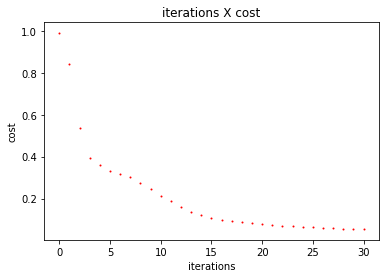

In [8]:
train_pkg_adder = train(X, T["ADDER"], hidden_layers=[32,64,32], epochs=10_000_000,\
                    rho=.3, normalize_data=True, show_cost=1)#, w_transfer=W)   
match_adder = match_logic_gate(X, T["ADDER"], train_pkg_adder)

### matches
matches is a Python dictionary. For ex: 

    matches
    returns a list:
            matches[0] == boolean (converged or not, True or False)
            matches[1] == idx_done, no. of iterations to converge
            matches[2] == total iterations (epochs)
            matches[3] == learning rate used(rho)
            matches[4] == matches with target (comparing both F_out and C_out))
            matches[5] == predicted Y

In [9]:
print("binary adder with carry ====================================")
print("    converged: " + str(match_adder[0]))
print("    no. of iterations to converge: " + str(match_adder[1]))
print("    total iterations set: " + str(match_adder[2]))
print("    learning reate: " + str(match_adder[3]))
print("    matches with target: " + str(match_adder[4]))
print("    prediction: ")
print(match_adder[5])


binary adder with carry ====================================
    converged: True
    no. of iterations to converge: 17
    total iterations set: 10000000
    learning reate: 0.3
    matches with target: True
    prediction: 
[[0. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]]
